#imports

In [2]:
import numpy as np
import math
from PIL import Image
import random
from functools import partial
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torch.nn as nn
from torch.nn import AdaptiveAvgPool3d
import torch.utils.data as data
from torch import Tensor
import torch.optim as optim
import torchvision
from torchvision.datasets import MNIST
from torchvision import transforms
from mpl_toolkits import mplot3d
%matplotlib inline
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
from mpl_toolkits import mplot3d
import numpy as np
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from sklearn.metrics import pairwise_distances

#Question 3

## a

In [26]:
class Rotations(torch.nn.Module):
    """
    We create here a class that has all the toations at ones.
    """
    def __init__(self, deg):
        super().__init__()
        self.register_buffer('identity', torch.Tensor([0.]))
        self.deg = torch.tensor([ np. pi * deg /180])
        self.order = 4

    def __product__(self, g1, g2):
        return torch.remainder(g1 +g2, 2 * np.pi)

    def inversed(self, h):
        return torch.remainder(-h, 2 * np.pi)

    def __mul__(self, x):
      transformed_x = torch.tensordot(self.matrix_representation(self.deg), x, dims=1)
      return transformed_x

    def matrix_representation(self, h):
        cos_t = torch.cos(h)
        sin_t = torch.sin(h)

        representation = torch.tensor([
            [cos_t, -sin_t],
            [sin_t, cos_t]
        ], device=self.identity.device)
        return representation

    def normalize_group_elements(self, h):
        """ Normalize values of group elements to range between -1 and 1.
        The group elements range from 0 to 2pi * (self.order - 1) / self.order,
        so we normalize accordingly.

        @param h: A group element.
        @return normalized_h: Tensor containing normalized value corresponding to element h.
        """
        largest_elem = 2 * np.pi * (self.order - 1) / self.order
        normalized_h = (2*h / largest_elem) - 1.
        return normalized_h

In [27]:
dummy = Rotations(0)
all_rotations_degrees = torch.tensor([Rotations(i*90).deg for i in range(4)])

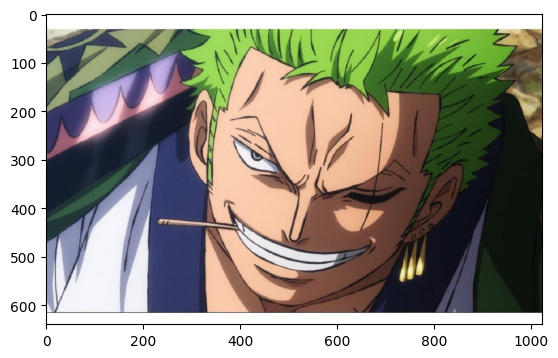

In [28]:
img = img = Image.open("/content/zoro.jpg")
img_tensor = transforms.ToTensor()(img)
plt.imshow(img)
plt.show()

In [29]:
def bilinear_interpolation(signal, grid):
    """ Obtain signal values for a set of gridpoints through bilinear interpolation.

    @param signal: Tensor containing pixel values [C, H, W] or [N, C, H, W]
    @param grid: Tensor containing coordinate values [2, H, W] or [2, N, H, W]
    """
    # If signal or grid is a 3D array, add a dimension to support grid_sample.
    if len(signal.shape) == 3:
        signal = signal.unsqueeze(0)
    if len(grid.shape) == 3:
        grid = grid.unsqueeze(1)

    # Grid_sample expects [N, H, W, 2] instead of [2, N, H, W]
    grid = grid.permute(1, 2, 3, 0)

    # Grid sample expects YX instead of XY.
    grid = torch.roll(grid, shifts=1, dims=-1)

    return torch.nn.functional.grid_sample(
        signal,
        grid,
        padding_mode='zeros',
        align_corners=True,
        mode="bilinear"
    )

def trilinear_interpolation(signal, grid):
    """

    @param signal: Tensor containing pixel values [C, D, H, W] or [N, C, D, H, W]
    @param grid: Tensor containing coordinate values [3, D, H, W] or [3, N, D, H, W]
    """
    # If signal or grid is a 4D array, add a dimension to support grid_sample.
    if len(signal.shape) == 4:
        signal = signal.unsqueeze(0)
    if len(grid.shape) == 4:
        grid = grid.unsqueeze(1)

    # Grid_sample expects [N, D, H, W, 3] instead of [3, N, D, H, W]
    grid = grid.permute(1, 2, 3, 4, 0)

    # Grid sample expects YX instead of XY.
    grid = torch.roll(grid, shifts=1, dims=-1)

    return torch.nn.functional.grid_sample(
        signal,
        grid,
        padding_mode='zeros',
        align_corners=True,
        mode="bilinear" # actually trilinear in this case...
    )


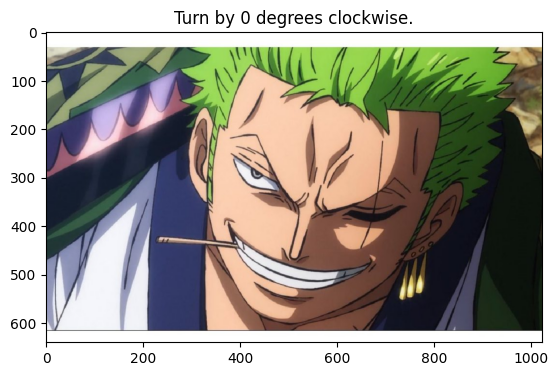

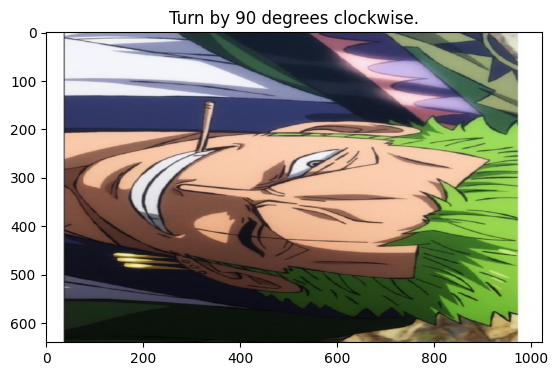

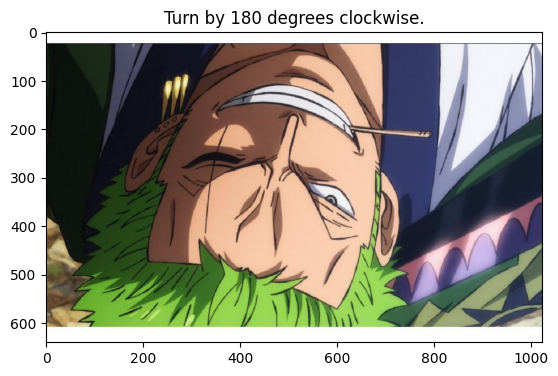

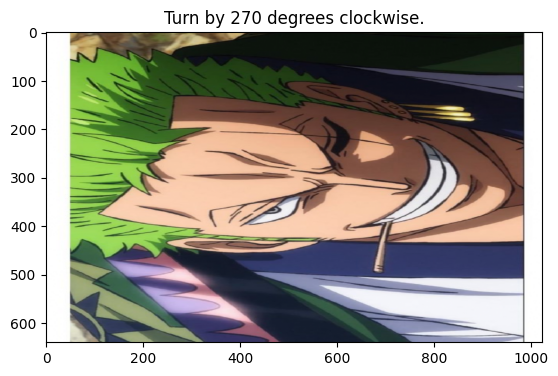

In [30]:
img_grid = torch.stack(torch.meshgrid(
    torch.linspace(-1, 1, img_tensor.shape[-2]),
    torch.linspace(-1, 1, img_tensor.shape[-1]),
    indexing='ij'
))

for i in range(4):
  g= Rotations(i*90)
  transformed_img_grid = g * img_grid
  transformed_img = bilinear_interpolation(img_tensor, transformed_img_grid)[0]
  photo= transforms.ToPILImage()(transformed_img)
  plt.imshow(photo)
  plt.title("Turn by " + str(90*i)+ " degrees clockwise.")
  plt.show()

## b

In [31]:
class LiftingConvolution(torch.nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size, padding):
        super().__init__()

        self.kernel_size = kernel_size
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.padding = padding
        self.weight = torch.nn.Parameter(torch.zeros((
                    self.out_channels,
                    self.in_channels,
                    self.kernel_size,
                    self.kernel_size
                )))

        self.register_buffer("grid_R2", torch.stack(torch.meshgrid(
            torch.linspace(-1., 1., self.kernel_size),
            torch.linspace(-1., 1., self.kernel_size),
            indexing='ij'
        )))

        self.register_buffer("transformed_grid_R2", self.create_transformed_grid_R2())
        # Initialize weights using kaiming uniform intialisation.
        torch.nn.init.kaiming_uniform_(self.weight.data, a=math.sqrt(5))

    def create_transformed_grid_R2(self):
        """Transform the created grid by the group action of each group element.
        This yields a grid (over H) of spatial grids (over R2). In other words,
        a list of grids, each index of which is the original spatial grid transformed by
        a corresponding group element in H.

        """

        # Transform the grid defined over R2 with the sampled group elements.
        # Recall how the left-regular representation acts on the domain of a
        # function on R2! (Hint: look closely at the equation given under 1.3)
        # We'd like to end up with a grid of shape [2, |H|, kernel_size, kernel_size].

        transformed_grids = []
        for element in all_rotations_degrees:
            g_inverse = dummy.inversed(element)
            transformed_grids.append(
                g_inverse* self.grid_R2
            )
        transformed_grid = torch.stack(transformed_grids, dim=1)

        return transformed_grid

    def sample(self):
        """ Sample convolution kernels for a given number of group elements
        should return:
        :return kernels: filter bank extending over all input channels,
            containing kernels transformed for all output group elements.
        """
        weight = self.weight.view(
            self.out_channels * self.in_channels,
            self.kernel_size,
            self.kernel_size
        )

        transformed_weight = []
        for spatial_grid_idx in range(all_rotations_degrees.numel()):
            transformed_weight.append(
                bilinear_interpolation(weight, self.transformed_grid_R2[:, spatial_grid_idx, :, :])
            )
        transformed_weight = torch.stack(transformed_weight)

        # Separate input and output channels.
        transformed_weight = transformed_weight.view(
            all_rotations_degrees.numel(),
            self.out_channels,
            self.in_channels,
            self.kernel_size,
            self.kernel_size
        )

        # Put out channel dimension before group dimension. We do this
        # to be able to use pytorched Conv2D. Details below!
        transformed_weight = transformed_weight.transpose(0, 1)

        return transformed_weight


    def forward(self, x):
        """ Perform lifting convolution
        @param x: Input sample [batch_dim, in_channels, spatial_dim_1,
            spatial_dim_2]
        @return: Function on a homogeneous space of the group
            [batch_dim, out_channels, num_group_elements, spatial_dim_1,
            spatial_dim_2]
        """
        conv_kernels = self.sample()

        x = torch.nn.functional.conv2d(
            input=x,
            weight=conv_kernels.reshape(
                self.out_channels * all_rotations_degrees.numel(),
                self.in_channels,
                self.kernel_size,
                self.kernel_size
            ),
            padding=self.padding
        )

        # Reshape [batch_dim, in_channels * num_group_elements, spatial_dim_1,
        # spatial_dim_2] into [batch_dim, in_channels, num_group_elements,
        # spatial_dim_1, spatial_dim_2], separating channel and group
        # dimensions.
        x = x.view(
            -1,
            self.out_channels,
           all_rotations_degrees.numel(),
            x.shape[-1],
            x.shape[-2]
        )

        return x


## c

In [32]:
class GroupConvolution(torch.nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size, padding):
        super().__init__()

        self.kernel_size = kernel_size
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.padding = padding

        self.weight = torch.nn.Parameter(torch.zeros((
                self.out_channels,
                self.in_channels,
                all_rotations_degrees.numel(), # this is different from the lifting convolution
                self.kernel_size,
                self.kernel_size
            )))

        torch.nn.init.kaiming_uniform_(self.weight.data, a=math.sqrt(5))

        self.register_buffer("grid_R2", torch.stack(torch.meshgrid(
                    torch.linspace(-1., 1., self.kernel_size),
                    torch.linspace(-1., 1., self.kernel_size),
                    indexing='ij'
                )))

        self.register_buffer("grid_H", all_rotations_degrees)
        self.register_buffer("transformed_grid_R2xH", self.create_transformed_grid_R2xH())

    def create_transformed_grid_R2xH(self):
        """Transform the created grid over R^2 \rtimes H by the group action of
        each group element in H.

        This yields a set of grids over the group. In other words, a list of
        grids, each index of which is the original grid over G transformed by
        a corresponding group element in H.
        """
        group_elements = all_rotations_degrees
        transformed_grid_R2 = []
        for g_inverse in group_elements:
            g_inverse = dummy.inversed(g_inverse)
            transformed_grid_R2.append(
                g_inverse*self.grid_R2
            )
        transformed_grid_R2 = torch.stack(transformed_grid_R2, dim=1)
        transformed_grid_H = []
        for g_inverse in group_elements:
            g_inverse = dummy.inversed(g_inverse)
            transformed_grid_H.append(
                    g_inverse+ self.grid_H
            )
        transformed_grid_H = torch.stack(transformed_grid_H, dim=1)
        transformed_grid_H = Rotations(0).normalize_group_elements(transformed_grid_H)
        transformed_grid = torch.cat(
            (
                transformed_grid_R2.view(
                    2,
                    group_elements.numel(),
                    1,
                    self.kernel_size,
                    self.kernel_size,
                ).repeat(1, 1, group_elements.numel(), 1, 1),
                transformed_grid_H.view(
                    1,
                    group_elements.numel(),
                    group_elements.numel(),
                    1,
                    1,
                ).repeat(1, 1, 1, self.kernel_size, self.kernel_size)
            ),
            dim=0
        )
        return transformed_grid

    def sample(self):
        """ Sample convolution kernels for a given number of group elements

        should return:
        :return kernels: filter bank extending over all input channels,
            containing kernels transformed for all output group elements.
        """
        weight = self.weight.view(
            self.out_channels * self.in_channels,
            all_rotations_degrees.numel(),
            self.kernel_size,
            self.kernel_size
        )

        transformed_weight = []
        for grid_idx in range(all_rotations_degrees.numel()):
            transformed_weight.append(
                trilinear_interpolation(weight, self.transformed_grid_R2xH[:, grid_idx, :, :, :])
            )
        transformed_weight = torch.stack(transformed_weight)

        # Separate input and output channels.
        transformed_weight = transformed_weight.view(
            all_rotations_degrees.numel(),
            self.out_channels,
            self.in_channels,
            all_rotations_degrees.numel(),
            self.kernel_size,
            self.kernel_size
        )

        # Put out channel dimension before group dimension. We do this
        # to be able to use pytorched Conv2D. Details below!
        transformed_weight = transformed_weight.transpose(0, 1)

        return transformed_weight


    def forward(self, x):
        """ Perform lifting convolution

        @param x: Input sample [batch_dim, in_channels, group_dim, spatial_dim_1,
            spatial_dim_2]
        @return: Function on a homogeneous space of the group
            [batch_dim, out_channels, num_group_elements, spatial_dim_1,
            spatial_dim_2]
        """
        x = x.reshape(
            -1,
            x.shape[1] * x.shape[2],
            x.shape[3],
            x.shape[4]
        )
        conv_kernels = self.sample()

        # Apply group convolution, note that the reshape folds the 'output' group
        # dimension of the kernel into the output channel dimension, and the
        # 'input' group dimension into the input channel dimension.

        x = torch.nn.functional.conv2d(
            input=x,
            weight=conv_kernels.reshape(
                self.out_channels * all_rotations_degrees.numel(),
                self.in_channels * all_rotations_degrees.numel(),
                self.kernel_size,
                self.kernel_size
            ),
            padding=self.padding
        )

        # Reshape [batch_dim, in_channels * num_group_elements, spatial_dim_1,
        # spatial_dim_2] into [batch_dim, in_channels, num_group_elements,
        # spatial_dim_1, spatial_dim_2], separating channel and group
        # dimensions.
        x = x.view(
            -1,
            self.out_channels,
            all_rotations_degrees.numel(),
            x.shape[-1],
            x.shape[-2],
        )

        return x

## d

In [33]:
class GroupEquivariantCNN(torch.nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size, num_hidden, hidden_channels):
        super().__init__()

        self.lifting_conv = LiftingConvolution(
            in_channels=in_channels,
            out_channels=hidden_channels,
            kernel_size=kernel_size,
            padding=0
        )

        self.gconvs = torch.nn.ModuleList()

        for i in range(num_hidden):
            self.gconvs.append(
                GroupConvolution(
                    in_channels=hidden_channels,
                    out_channels=hidden_channels,
                    kernel_size=kernel_size,
                    padding=0
                )
            )

        self.projection_layer = torch.nn.AdaptiveAvgPool3d(1)
        self.final_linear = torch.nn.Linear(hidden_channels, out_channels)



    def forward(self, x):

        # Lift and disentangle features in the input.
        x = self.lifting_conv(x)
        x = torch.nn.functional.layer_norm(x, x.shape[-4:])
        x = torch.nn.functional.relu(x)

        # Apply group convolutions.
        for gconv in self.gconvs:
            x = gconv(x)
            x = torch.nn.functional.layer_norm(x, x.shape[-4:])
            x = torch.nn.functional.relu(x)

        # to ensure equivariance, apply max pooling over group and spatial dims.
        x = self.projection_layer(x).squeeze()

        x = self.final_linear(x)
        return x

## e

In [34]:
transform_train = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(0.5, 0.5)])

train_batch_size = 128
test_batch_size = 4

trainset = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=train_batch_size,
                                          shuffle=True, num_workers=2)

h, w = 28, 28 # Image height and width for fashion mnist

def transform_rot(x, deg=None):
    if deg is None:
        deg =  90 * random.randint(0, 3)
    out = torchvision.transforms.functional.rotate(x,deg)
    return out

transform_test = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(0.5, 0.5),
     transform_rot])

testset = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=test_batch_size,
                                         shuffle=False, num_workers=2)

classes = ('T-shirt', 'Trouser', 'Pullover', 'Dress',
    'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')

## net

In [17]:
model = GroupEquivariantCNN(in_channels=1, out_channels=10, kernel_size=3, num_hidden=5, hidden_channels=16)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-5)

In [18]:
for epoch in range(3):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = loss_func(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 10 == 9:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,    10] loss: 0.011
[1,    20] loss: 0.011
[1,    30] loss: 0.011
[1,    40] loss: 0.010
[1,    50] loss: 0.010
[1,    60] loss: 0.010
[1,    70] loss: 0.010
[1,    80] loss: 0.010
[1,    90] loss: 0.009
[1,   100] loss: 0.009
[1,   110] loss: 0.009
[1,   120] loss: 0.009
[1,   130] loss: 0.009
[1,   140] loss: 0.009
[1,   150] loss: 0.008
[1,   160] loss: 0.008
[1,   170] loss: 0.008
[1,   180] loss: 0.007
[1,   190] loss: 0.007
[1,   200] loss: 0.009
[1,   210] loss: 0.008
[1,   220] loss: 0.007
[1,   230] loss: 0.007
[1,   240] loss: 0.007
[1,   250] loss: 0.007
[1,   260] loss: 0.006
[1,   270] loss: 0.006
[1,   280] loss: 0.006
[1,   290] loss: 0.007
[1,   300] loss: 0.006
[1,   310] loss: 0.006
[1,   320] loss: 0.006
[1,   330] loss: 0.006
[1,   340] loss: 0.006
[1,   350] loss: 0.006
[1,   360] loss: 0.006
[1,   370] loss: 0.006
[1,   380] loss: 0.006
[1,   390] loss: 0.005
[1,   400] loss: 0.005
[1,   410] loss: 0.005
[1,   420] loss: 0.005
[1,   430] loss: 0.005
[1,   440] 

In [ ]:
def show_image(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(testloader)
images, labels = next(dataiter)

In [19]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f'Accuracy of the network on the rotated 10000 test images: {100 * correct // total} %')

Accuracy of the network on the rotated 10000 test images: 35 %


Original image logits: [-988205.5, 678460.0, -609341.5, 102525.0390625, -980603.9375, 804400.25, -813780.9375, 1827092.75, -915227.125, 1439134.75]
Rotated image logits: [-1457986.125, 290091.875, -727967.5625, -62563.11328125, -990324.625, 925933.0625, -1080173.875, 2215414.25, -669140.875, 1400214.625]


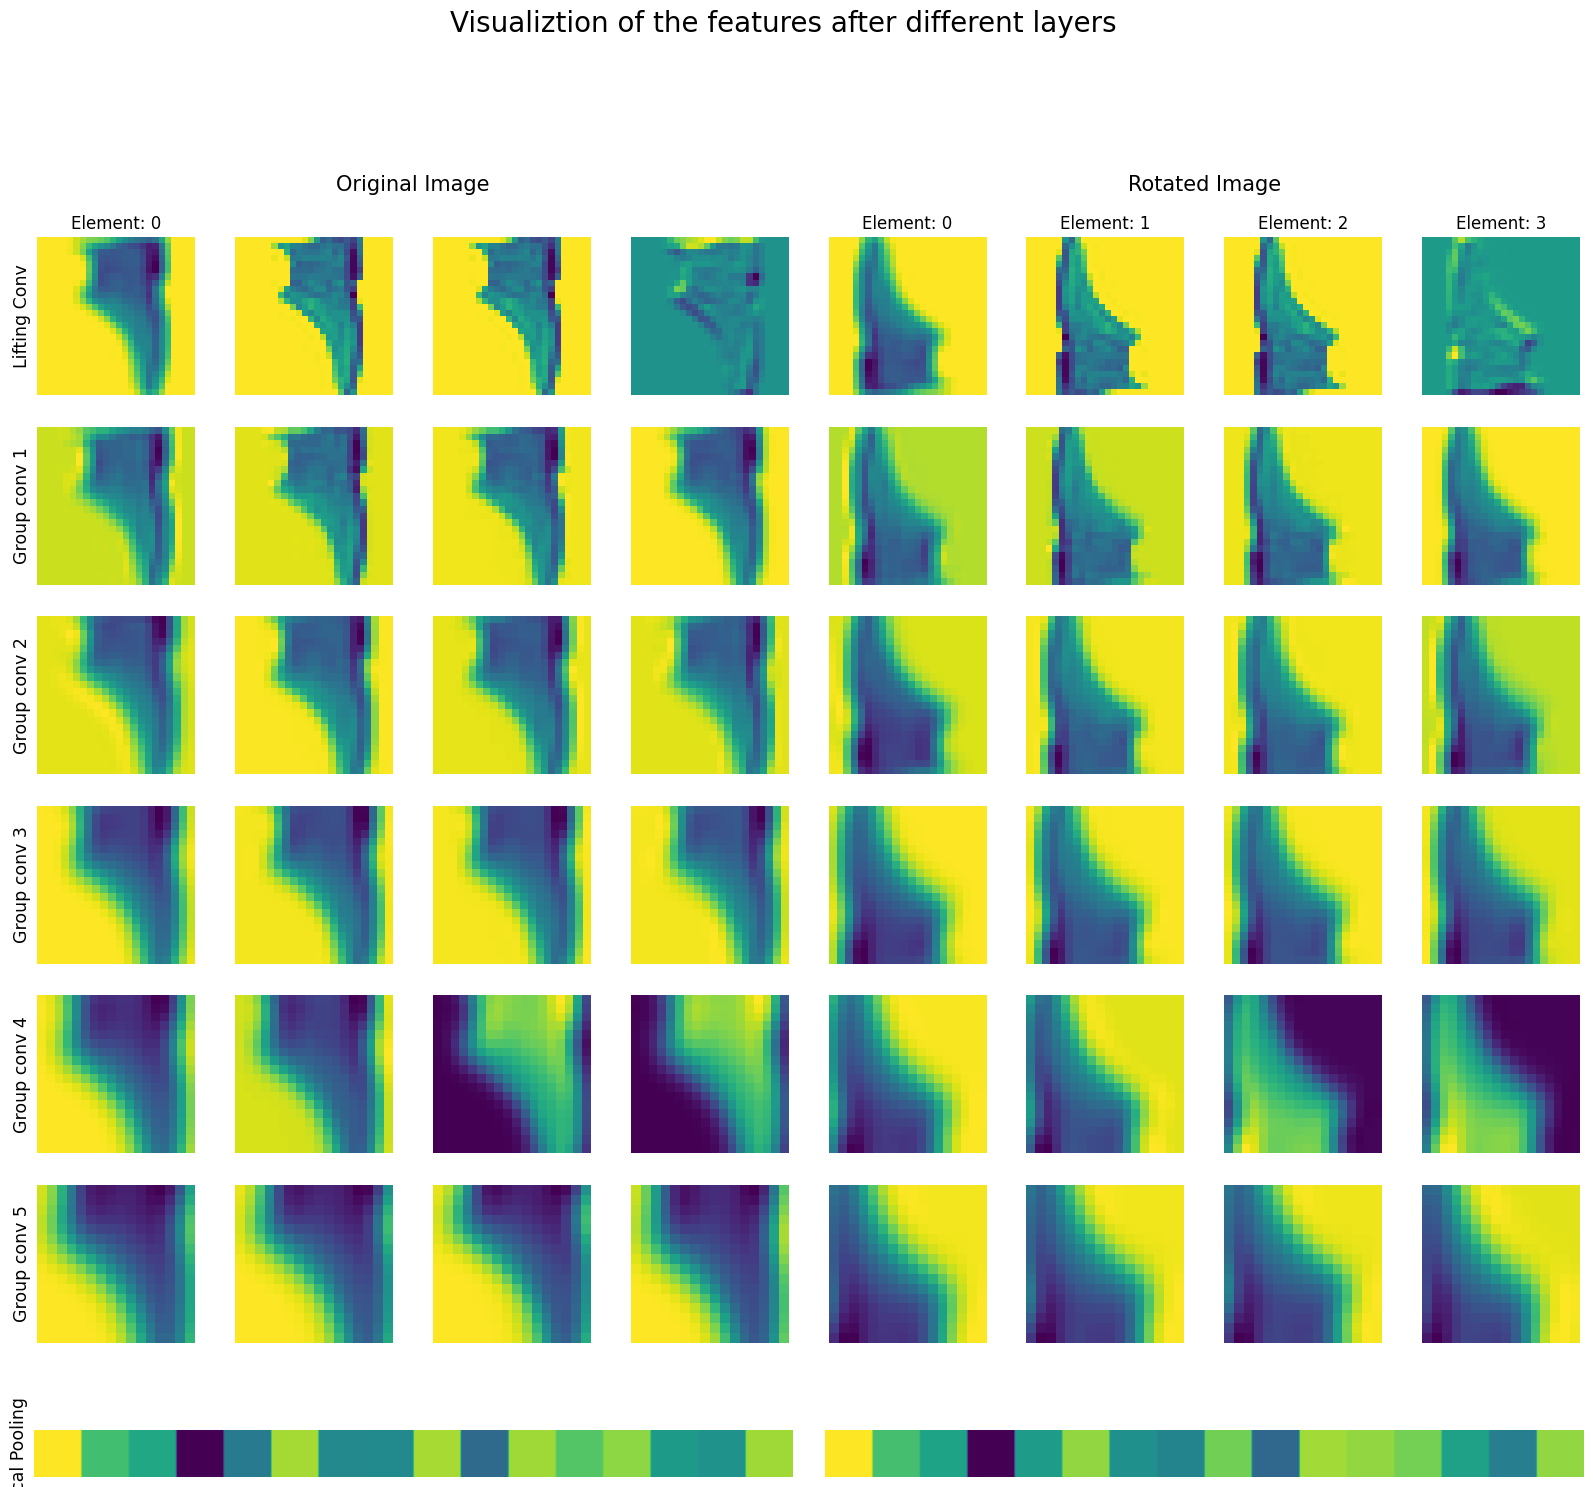

In [21]:
model.eval()
l = model.lifting_conv
c = [group_conv for group_conv in model.gconvs]

pooling = nn.AdaptiveAvgPool3d(1)
flatten = nn.Flatten(0)

dataiter = iter(testloader)
images, labels = next(dataiter)
img = images[0]
with torch.no_grad():
    h_map_lift = l(img.unsqueeze(0))
    last = h_map_lift
    h_map_convs = []
    for group_conv in c:
        conv_res = group_conv(last)
        h_map_convs.append(conv_res)
        last = conv_res
    h_map_pool = flatten(pooling(last))
    print(f'Original image logits: {model.final_linear(h_map_pool).tolist()}')
    h_map_lift, h_map_pool = h_map_lift.squeeze(), h_map_pool.squeeze()
    for idx, h_map_conv in enumerate(h_map_convs):
        h_map_convs[idx] = h_map_conv.squeeze()
    rot_img = transform_rot(img)
    h_rot_map_lift = l(rot_img.unsqueeze(0))
    last = h_rot_map_lift
    h_rot_map_convs = []
    for group_conv in c:
        conv_res = group_conv(last)
        h_rot_map_convs.append(conv_res)
        last = conv_res
    h_rot_map_pool = flatten(pooling(last))
    print(f'Rotated image logits: {model.final_linear(h_rot_map_pool).tolist()}')
    h_rot_map_lift, h_rot_map_pool = h_rot_map_lift.squeeze(), h_rot_map_pool.squeeze()
    for idx, h_rot_map_conv in enumerate(h_rot_map_convs):
        h_rot_map_convs[idx] = h_rot_map_conv.squeeze()

fig, ax = plt.subplots(2+len(h_map_convs), 8)

gs = ax[-1, 0].get_gridspec()
for a in ax[-1, :]:
    a.remove()
ax_pool = fig.add_subplot(gs[-1,:4])
ax_pool_rot = fig.add_subplot(gs[-1:, 4:])
ax_pool.set_xticks([])
ax_pool.set_yticks([])
ax_pool.spines['top'].set_visible(False)
ax_pool.spines['right'].set_visible(False)
ax_pool.spines['bottom'].set_visible(False)
ax_pool.spines['left'].set_visible(False)

fig.set_size_inches(w=20,h=(2 * 2.5 + 2.5*len(h_map_convs)))
fig.subplots_adjust(top=0.85)
fig.suptitle('Visualiztion of the features after different layers', fontsize=20)

ext = []

h_maps = [h_map_lift] + h_map_convs + [h_map_pool]
y_labels = ['Lifting Conv'] + [f'Group conv {j+1}' for j in range(len(h_map_convs))] + ['Local Pooling']
for group_elem in range(4):
    ax[0,0].set_title("Element: {}".format(0))
    for idx, h_map in enumerate(h_maps):
        ax[idx, group_elem].set_xticks([])
        ax[idx, group_elem].set_yticks([])
        ax[idx, group_elem].spines['top'].set_visible(False)
        ax[idx, group_elem].spines['right'].set_visible(False)
        ax[idx, group_elem].spines['bottom'].set_visible(False)
        ax[idx, group_elem].spines['left'].set_visible(False)

        if idx == len(h_maps)-1:
            if group_elem != 0:
                continue
            ax_pool.imshow(
                h_map.repeat_interleave(16).reshape(1,-1).repeat(16,1).detach().numpy()
            )
            ax_pool.set_ylabel(y_labels[idx], size=12.5)
        else:
            ax[idx, group_elem].imshow(
                h_map[0, group_elem, :, :].detach().numpy()
            )
        if group_elem == 0:
            ax[idx,group_elem].set_ylabel(y_labels[idx], size=12.5)
    ext.append([ax[0,group_elem].get_window_extent().x0, ax[0,group_elem].get_window_extent().width ])


h_maps = [h_rot_map_lift] + h_rot_map_convs + [h_rot_map_pool]
for group_elem in range(4):
    ext.append([ax[0,4+group_elem].get_window_extent().x0, ax[0,4+group_elem].get_window_extent().width ])
    ax[0,4+group_elem].set_title("Element: {}".format(group_elem))
    for idx, h_map in enumerate(h_maps):
        if idx == len(h_maps)-1:
            ax_pool_rot.axis('off')
            if group_elem != 0:
                continue
            ax_pool_rot.imshow(
                h_map.repeat_interleave(16).reshape(1,-1).repeat(16,1).detach().numpy()
            )
        else:
            ax[idx, 4+group_elem].axis('off')
            ax[idx, 4+group_elem].imshow(
                h_map[0, group_elem, :, :].detach().numpy()
            )

inv = fig.transFigure.inverted()
width_left = ext[0][0]+(ext[3][0]+ext[3][1]-ext[0][0])/2.
left_center = inv.transform( (width_left, 1) )
width_right = ext[4][0]+(ext[7][0]+ext[7][1]-ext[4][0])/2.
right_center = inv.transform( (width_right, 1) )
plt.figtext(left_center[0],0.88,"Original Image", va="center", ha="center", size=15)
plt.figtext(right_center[0],0.88,"Rotated Image", va="center", ha="center", size=15)

plt.show()

In [22]:
test_batch_size = 4

h, w = 28, 28 # Image height and width for fashion mnist

def transform_rot(x, deg=None):
    if deg is None:
        deg =  random.randrange(360)
    out = torchvision.transforms.functional.rotate(x,deg)
    return out

transform_test = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(0.5, 0.5),
     transform_rot])

testset = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=test_batch_size,
                                         shuffle=False, num_workers=2)

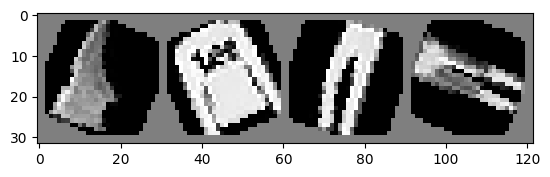

Ankle boot Pullover Trouser Trouser


In [23]:
dataiter = iter(testloader)
images, labels = next(dataiter)
show_image(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(test_batch_size)))

In [24]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the fully rotated 10000 test images: {100 * correct // total} %')

Accuracy of the network on the fully rotated 10000 test images: 29 %


The full rotational group is a continuous group, which means that it can represent any rotation, no matter how small or large. However, this can make it difficult to train a neural network to be invariant to rotations. One way to improve performance on general rotations is to approximate the full rotational group by a discrete group of rotations. This means that the network only needs to learn to be invariant to a finite number of rotations.

One possibility for a discrete group of rotations is to use the set of rotations that are multiples of 45 degrees. This would mean that the network would be invariant to rotations of 0 degrees, 45 degrees, 90 degrees, 135 degrees, and so on. This would be a more challenging problem than learning to be invariant to just two rotations, but it would also be more generalizable.

Due to colab isues I couldn't train for more than 3 epochs but still, the results are statisfying.

#Quesion 4

## b.i

In [51]:
n = 50 # the n from the exercise
m = 20 # the m from the exercise
Num_nodes = n*m
np.set_printoptions(precision=4, threshold=200, edgeitems=4)

In [52]:
def get_laplacian_and_degree_mat(adjacency_mat):
    ''' Compute the degree matrix and laplacian
    given the adjacency matrix, same as the function in HW1'''
    degree_arr = np.sum(adjacency_mat, axis=1)
    degree_mat = np.zeros_like(adjacency_mat)
    size = adjacency_mat.shape[0]
    arange = np.arange(size)
    degree_mat[arange, arange] = degree_arr
    return degree_mat, degree_mat - adjacency_mat

In [53]:
def get_ring_adj_mat(dim):
  ring_adjacency_mat = np.zeros((dim, dim))
  rng = np.arange(dim)
  ring_adjacency_mat[rng, (rng+1)%dim] = 1
  ring_adjacency_mat[(rng+1)%dim, rng] = 1
  return ring_adjacency_mat

In [54]:
Adj1 = get_ring_adj_mat(n)
deg1, Lap1 = get_laplacian_and_degree_mat(Adj1)
Adj2 = get_ring_adj_mat(m)
deg2, Lap2 = get_laplacian_and_degree_mat(Adj2)
AdjG = np.kron(Adj1,np.eye(m) ) + np.kron(np.eye(n),Adj2)
DegG, LapG = get_laplacian_and_degree_mat(AdjG)

In [55]:
def get_eigen_values_and_vectors(mat, accuracy):
  vals, vecs = np.linalg.eigh(mat)
  vals = np.around(vals, accuracy)
  vecs = np.around(vecs, accuracy)
  return vals, vecs

In [56]:
accuracy = 10
eig_vals_LapG, eig_vecs_LapG = get_eigen_values_and_vectors(LapG, accuracy)
eig_vals_Lap1, eig_vecs_Lap1 = get_eigen_values_and_vectors(Lap1, accuracy)
eig_vals_Lap2, eig_vecs_Lap2 = get_eigen_values_and_vectors(Lap2, accuracy)
# Sanity Checks
sanity_sum_eig = list()
for i in eig_vals_Lap1:
  for j in eig_vals_Lap2:
    sanity_sum_eig.append(np.around((i+j),accuracy))
sanity_sum_eig.sort()
print(np.allclose(sanity_sum_eig,eig_vals_LapG,atol=1.e-4,rtol=0))

True


## b.ii

### b.ii.1

In [57]:
def generate_torus_mesh(m, n, center, radius):
    theta_vals = np.linspace(0, 2*np.pi, n)
    phi_vals = np.linspace(0, 2*np.pi, m)
    theta_vals, phi_vals = np.meshgrid(theta_vals, phi_vals)
    x_vals = (center + radius * np.cos(phi_vals)) * np.cos(theta_vals)
    y_vals = (center + radius * np.cos(phi_vals)) * np.sin(theta_vals)
    z_vals = radius * np.sin(phi_vals)
    return x_vals, y_vals, z_vals

graph_data = nx.DiGraph(np.array(AdjG))

num_nodes = graph_data.number_of_nodes()
num_edges = graph_data.number_of_edges()

x_nodes, y_nodes, z_nodes = generate_torus_mesh(m, n, 2, 1)
x_nodes_flat = x_nodes.flatten()
y_nodes_flat = y_nodes.flatten()
z_nodes_flat = z_nodes.flatten()

edges_list = graph_data.edges()

node_coordinates = dict(zip(np.arange(num_nodes), zip(*[x_nodes_flat, y_nodes_flat, z_nodes_flat])))

x_edges = []
y_edges = []
z_edges = []

# Populate edge coordinates
for edge in edges_list:
    edge_coords = [node_coordinates[edge[0]][0], node_coordinates[edge[1]][0], None] * 100
    x_edges += edge_coords

    edge_coords = [node_coordinates[edge[0]][1], node_coordinates[edge[1]][1], None] * 100
    y_edges += edge_coords

    edge_coords = [node_coordinates[edge[0]][2], node_coordinates[edge[1]][2], None] * 100
    z_edges += edge_coords

edge_trace = go.Scatter3d(x=x_edges, y=y_edges, z=z_edges, mode='lines', line=dict(color='black', width=2),
                          hoverinfo='none')

# Create trace for nodes
node_trace = go.Scatter3d(x=x_nodes_flat, y=y_nodes_flat, z=z_nodes_flat, mode='markers',
                          marker=dict(symbol='circle', size=5, colorscale=['lightgreen', 'magenta'],
                                      line=dict(color='cyan', width=0.5)),
                          hoverinfo='text')

# Define axis settings
axis_settings = dict(showbackground=False, showline=False, zeroline=False, showgrid=False, showticklabels=False,
                     title='')

# Create layout for the plot
plot_layout = go.Layout(
    title="Torus Graph",
    width=650,
    height=625,
    showlegend=False,
    scene=dict(xaxis=dict(axis_settings), yaxis=dict(axis_settings), zaxis=dict(axis_settings)),
    margin=dict(t=100),
    hovermode='closest'
)

In [48]:
data = [edge_trace, node_trace]
fig = go.Figure(data=data, layout=plot_layout)
fig.show()

### b.ii.2

Text(0.5, 1.0, 'Eigenvalues of L(G)')

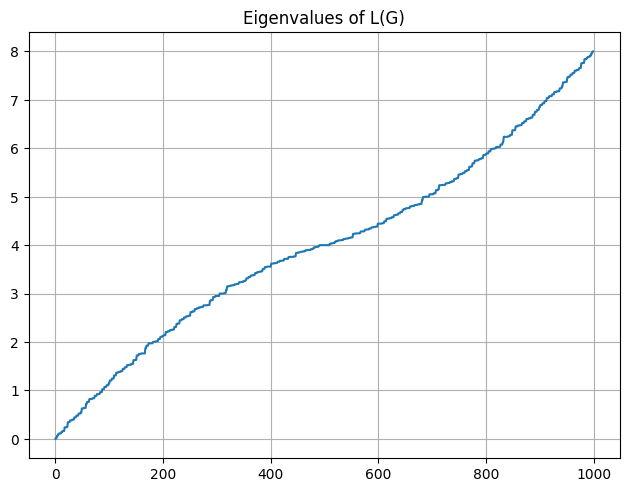

In [49]:
plt.plot(eig_vals_LapG)
plt.grid()
plt.tight_layout()
plt.title('Eigenvalues of L(G)')

### b.ii.3

In [ ]:
vec_list = [0,1,5,9]
for vec_idx in vec_list:
      layout = go.Layout(title=f"Topology of G colored by its {vec_idx + 1} eigenvector",
                width=650,
                height=625,
                showlegend=False,
                scene=dict(xaxis=dict(axis_settings),
                        yaxis=dict(axis_settings),
                        zaxis=dict(axis_settings),
                        ),
                margin=dict(t=100),
                hovermode='closest')
      trace_nodes = go.Scatter3d(x=x_nodes,
                                 y=y_nodes,
                                 z=z_nodes,
                                 mode='markers',
                                 marker=dict(symbol='circle',
                                             size=5,
                                             color=eig_vecs_LapG[:,vec_idx], #color the nodes according to their community
                                            #  colorscale=['lightgreen','magenta'], #either green or mageneta
                                             line=dict(color='black', width=0.5)),
                                     # text=club_labels,
                                      hoverinfo='text'
                                      )
      data = [edge_trace, node_trace]
      fig = go.Figure(data=data, layout=layout)
      fig.show()

In [15]:
k = np.linspace(0,n-1,n)
mm = np.linspace(0,m-1,20)

lambda_n = 2 * (1 - np.cos(2*np.pi*k/n))
lambda_m = 2 * (1 - np.cos(2*np.pi*mm/m))
xv, yv = np.meshgrid(lambda_n,lambda_m)
ansum = xv + yv
ansum = np.sort(ansum.reshape(-1))

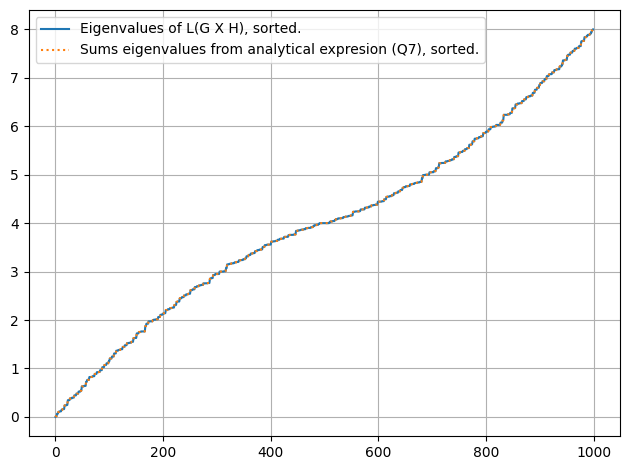

In [16]:
plt.plot(eig_vals_LapG,'-',label='Eigenvalues of L(G X H), sorted.')
plt.plot(ansum,':', label = 'Sums eigenvalues from analytical expresion (Q7), sorted.')
plt.grid()
plt.legend()
plt.tight_layout()

In [38]:
a, i = np.random.randint(0,49,2)
b, j = np.random.randint(0,19,2)
print(f"(a, b) = {a,b}")
print(f"(i, j) = {i,j}")
print(eig_vecs_Lap1.shape)
print(eig_vecs_Lap2.shape)
print(eig_vecs_LapG.shape)
phipsi_ij = eig_vecs_LapG[a*20+b,i*20+j]
print(eig_vecs_Lap1[a,i])
print(eig_vecs_Lap2[b,j])
print(eig_vecs_Lap2[a,i]*eig_vecs_Lap2[b,j])
print(phipsi_ij)

(a, b) = (35, 18)
(i, j) = (31, 12)
(50, 50)
(20, 20)
(1000, 1000)
-0.1902113033
0.1996812685
0.0


In [21]:
a, i = np.random.randint(0,49,2)
b, j = np.random.randint(0,19,2)
print(f"a={a} , b={b}")
print(eig_vecs_Lap1[a,i], eig_vecs_Lap2[b,j])
print(eig_vecs_Lap1[a,i]*eig_vecs_Lap2[b,j])
print(eig_vecs_LapG[20*a+b,20*i+j])

a=10 , b=3
0.1902113033 0.1122802218
0.021356967323391072
-0.0362424559


In [23]:
np.where(eig_vecs_LapG == eig_vecs_Lap1[a,i]*eig_vecs_Lap2[b,j])

(array([], dtype=int64), array([], dtype=int64))

In [24]:
def find_closest(arr, val):
       idx = np.abs(arr - val).argmin()
       return arr[idx], idx

In [26]:
val, idx = find_closest(eig_vecs_LapG.T.flatten(), eig_vecs_Lap1[a,i]*eig_vecs_Lap2[b,j])
print(val, idx)
kidx = np.unravel_index(idx,[1000,1000])
print(f"i={i}, j={j}, a={a}, b={b}, k_ij={kidx}")

0.0213569094 149123
i=38, j=6, a=10, b=3, k_ij=(149, 123)


expression from 10 for eigenvectors

In [28]:
a, i = np.random.randint(0,49,2)
b, j = np.random.randint(0,19,2)
print(f"i={i}, j={j}, a={a}, b={b}, k_ij={kidx}")
lambda_mu = eig_vals_Lap1[i]+eig_vals_Lap2[j]
right_hand_side = lambda_mu*eig_vecs_Lap1[a,i]*eig_vecs_Lap2[b,j]
left_hand_side = LapG@np.kron(eig_vecs_Lap1[:,i],eig_vecs_Lap2[:,j])
val, idx = find_closest(left_hand_side,right_hand_side)
right_hand_side, val,idx

i=15, j=0, a=5, b=5, k_ij=(149, 123)


(-0.012829431855184802, -0.012829431856389389, 400)

In [30]:
left_hand_side_as_mat = left_hand_side.reshape(50,20)
np.around(left_hand_side_as_mat[a,b],10) == np.around(right_hand_side,10)

True

#Question 5

In [ ]:
pointcloud_df = pd.read_csv('/content/toilet_0001.off')# loading the point cloud
pointcloud_df = pointcloud_df.iloc[1:3740]
pointcloud_df = pointcloud_df['OFF'].str.split(' ', expand=True) # split the x,y,z cordinates.
pointcloud_df = pointcloud_df.astype(float)
pointcloud_arr = np.asarray(pointcloud_df.to_numpy())

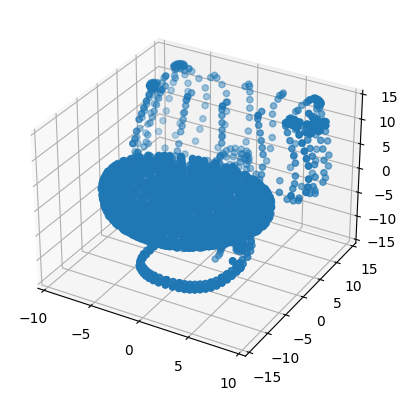

In [36]:
fig = plt.figure()
ax = plt.axes(projection="3d")
ax.scatter(pointcloud_arr[:,0], pointcloud_arr[:,1], pointcloud_arr[:,2])


#### Adding Noise

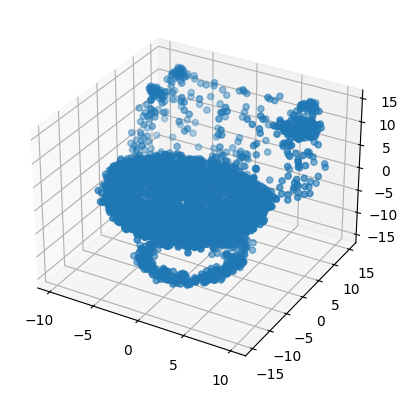

In [171]:
s = 4
sigma = 0.1*s
noise = sigma*np.random.standard_normal(size=pointcloud_arr.shape)
noisy_arr = pointcloud_arr + noise
fig = plt.figure()
ax = plt.axes(projection="3d")
ax.scatter(noisy_arr[:,0], noisy_arr[:,1], noisy_arr[:,2])

In [173]:
def compute_normalized_laplacian_mat(adjacency_mat, degree_mat):
    inverse_root_deg = np.diag(1/np.sqrt(np.diag(degree_mat)))
    return np.eye(adjacency_mat.shape[0]) - inverse_root_deg @ adjacency_mat @ inverse_root_deg

In [174]:
r = 2
std = 4

dists = pairwise_distances(noisy_arr, noisy_arr)
dists = np.asarray(dists)
mask = (dists < r)
affinity_mat = mask * np.exp(- dists ** 2 / std ** 2)
degree_mat, _ = get_laplacian_and_degree_mat(affinity_mat)
normalized_laplacian = compute_normalized_laplacian_mat(affinity_mat, degree_mat)
eig_vals, eig_vecs = np.linalg.eigh(normalized_laplacian)
eig_vals = np.around(eig_vals, decimals=5)
eig_vecs = np.around(eig_vecs, decimals=5)
plt.plot(eig_vals)

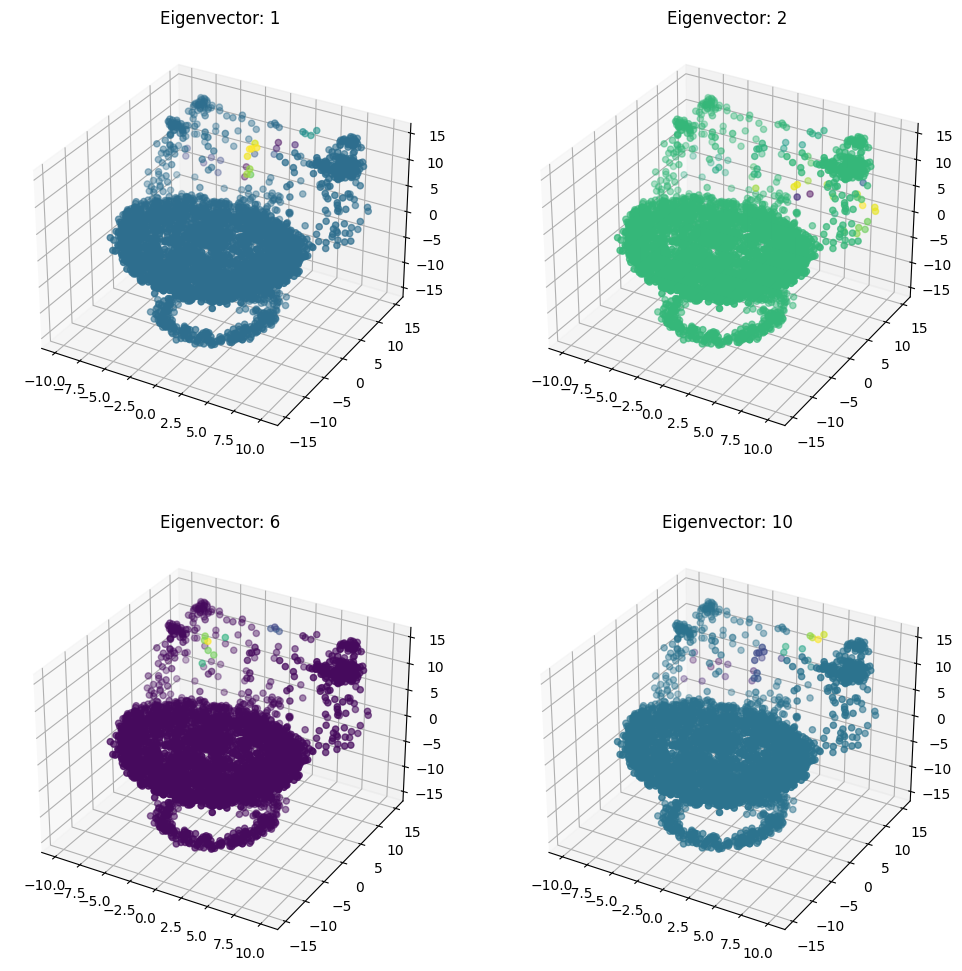

In [177]:
vec_list = [0,1,5,9]
fig, ax = plt.subplots(2,2, subplot_kw={'projection': '3d'})
fig.set_size_inches(12, 12)
for i in {0,1}:
    for j in {0,1}:
        ax[i,j].set_title(f'Eigenvector: {vec_list[2*i+j]+1}')
        ax[i,j].scatter(noisy_arr[:,0], noisy_arr[:,1], noisy_arr[:,2], c=eig_vecs[:,vec_list[2*i+j]])

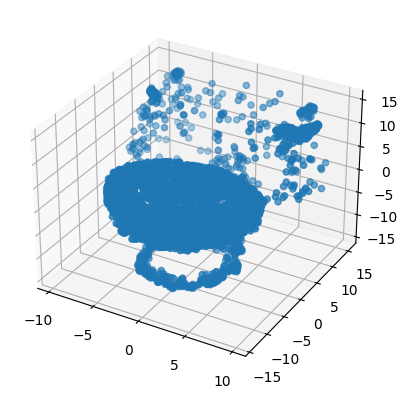

In [180]:
tau = 1
l_max = eig_vals[-1]
# Graph filtering

H = np.diag(np.exp(-tau*eig_vals/l_max))
filtered_arr = eig_vecs @ H @ eig_vecs.T @ noisy_arr
fig = plt.figure()
ax = plt.axes(projection="3d")
ax.scatter(filtered_arr[:,0], filtered_arr[:,1], filtered_arr[:,2])

To verify the results i repeat the procedure for another cloud.

#### Load and plot

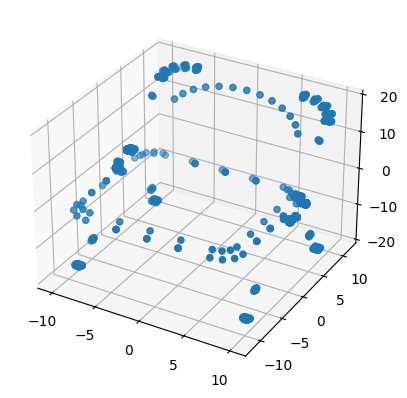

In [40]:
pointcloud_df = pd.read_csv('/content/chair_0001.off')
pointcloud_df = pointcloud_df.iloc[1:2383]
pointcloud_df = pointcloud_df['OFF'].str.split(' ', expand=True)
pointcloud_df = pointcloud_df.astype(float)
pointcloud_arr = np.asarray(pointcloud_df.to_numpy())
fig = plt.figure()
ax = plt.axes(projection="3d")
ax.scatter(pointcloud_arr[:,0], pointcloud_arr[:,1], pointcloud_arr[:,2])

#### Noise the point cloud

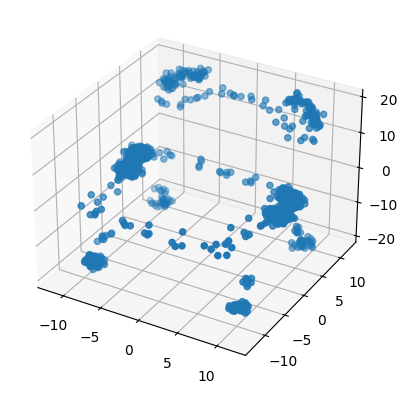

In [217]:
s = 5
sigma = 0.1*s
noise = sigma*np.random.standard_normal(size=pointcloud_arr.shape)
noisy_arr = pointcloud_arr + noise
fig = plt.figure()
ax = plt.axes(projection="3d")
ax.scatter(noisy_arr[:,0], noisy_arr[:,1], noisy_arr[:,2])

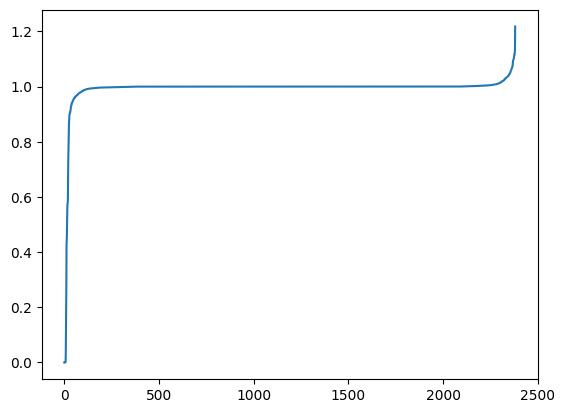

In [221]:
r = 5
std = 10
dists = pairwise_distances(noisy_arr, noisy_arr)
dists = np.asarray(dists)
mask = (dists < r)
affinity_mat = mask * np.exp(- dists ** 2 / std ** 2)
degree_mat, _ = get_laplacian_and_degree_mat(affinity_mat)
normalized_laplacian = compute_normalized_laplacian_mat(affinity_mat, degree_mat)
eig_vals, eig_vecs = np.linalg.eigh(normalized_laplacian)
eig_vals = np.around(eig_vals, decimals=5)
eig_vecs = np.around(eig_vecs, decimals=5)
plt.plot(eig_vals)

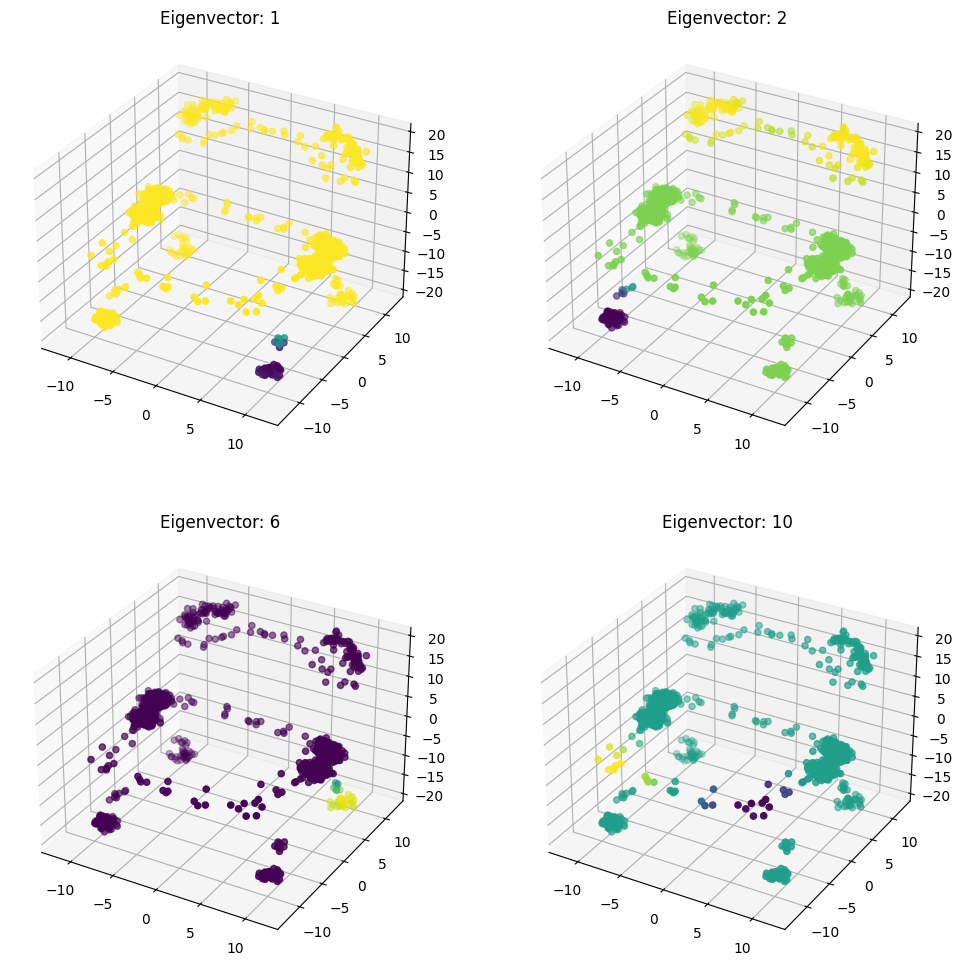

In [222]:
vec_list = [0,1,5,9]
fig, ax = plt.subplots(2,2, subplot_kw={'projection': '3d'})
fig.set_size_inches(12, 12)
for i in {0,1}:
    for j in {0,1}:
        ax[i,j].set_title(f'Eigenvector: {vec_list[2*i+j]+1}')
        ax[i,j].scatter(noisy_arr[:,0], noisy_arr[:,1], noisy_arr[:,2], c=eig_vecs[:,vec_list[2*i+j]])

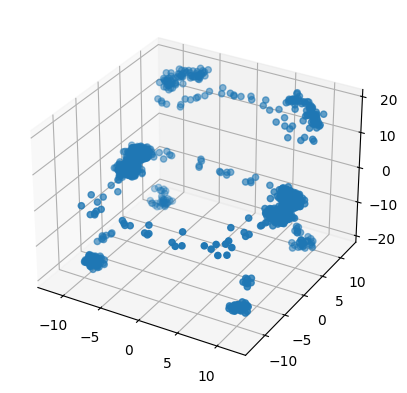

In [241]:
tau = 0.2
l_max = eig_vals[-1]
H = np.diag(np.exp(-tau*eig_vals/l_max))
filtered_arr = eig_vecs @ H @ eig_vecs.T @ noisy_arr
fig = plt.figure()
ax = plt.axes(projection="3d")
ax.scatter(filtered_arr[:,0], filtered_arr[:,1], filtered_arr[:,2])

Evidently, we successfully eliminated a significant portion of the noise. When we elevate the standard deviation parameter (s) for the white noise, the task of eliminating the noise becomes more challenging.

The parameter tau exerts control over the potency of the filtering process. If tau is set to a large value, a considerable number of high frequencies are subjected to filtering. However, this approach can result in the loss of the genuine signal. Conversely, when tau assumes a smaller value, noise remains unfiltered.

The parameter r plays a role in determining the connectivity of the graph. A value that is excessively diminutive for r might lead to the emergence of numerous disjointed components. Conversely, setting r too high could cause disconnected fragments to establish connections.

The standard deviation parameter exerts influence over the intensity of the relationship between interconnected nodes in the graph. If this parameter is assigned a value that is overly slight, distant neighbors tend to resemble proximate neighbors excessively within the graph. Conversely, if the value is excessively elevated, the association with distant neighbors weakens substantially.